Classification of c-VAE augmented biosignals with LSTM for anomaly detection

In [1]:
# imports
from scipy import io, signal
import matplotlib.pyplot as plt
import dtcwt
import numpy as np
import itertools
import pywt
from pywt import wavedec

ModuleNotFoundError: No module named 'dtcwt'

In [2]:
def get_ecg(path):
    ta = io.loadmat(path)
    ta = ta['val']
    ta = np.array(ta)
    ta = np.reshape(ta, (ta.shape[1],))
    return ta



def plot_ecg(tit, path = "", x = None):
    if x == None:
        ta = get_ecg(path)
    else:
        ta = x

    plt.plot(ta)
    plt.title(tit)
    plt.show()

In [3]:
def get_A(x):
    coeffs = wavedec(x, 'db4', level=2)
    cA2, cD2, cD1 = coeffs
    return cA2

In [88]:
# data read
import glob

# normal
nsr_x = []
pr_x = []

# arrythmia
apb_x = []
afl_x = []
afib_x = []
svta_x = []
wpw_x = []
pvc_x = []
bigem_x = []
trigem_x = []
vt_x = []
ivr_x = []
vfl_x = []
fus_x = []
lbbb_x = []
rbbb_x = []
sdhb_x = []

# all signals

x_all = []

# normal
for f in glob.glob('MLII/1 */*.mat'):
    nsr_x.append(get_ecg(f))
    x_all.append(get_A(get_ecg(f)))

for f in glob.glob('MLII/17 */*.mat'):
    pr_x.append(get_ecg(f))
    x_all.append(get_A(get_ecg(f)))
    
    
# arrythmia    
for f in glob.glob('MLII/2 */*.mat'):
    apb_x.append(get_ecg(f))
    x_all.append(get_A(get_ecg(f)))
    
for f in glob.glob('MLII/3 */*.mat'):
    afl_x.append(get_ecg(f))
    x_all.append(get_A(get_ecg(f)))
    
for f in glob.glob('MLII/4 */*.mat'):
    afib_x.append(get_ecg(f))
    x_all.append(get_A(get_ecg(f)))
    
for f in glob.glob('MLII/5 */*.mat'):
    svta_x.append(get_ecg(f))
    x_all.append(get_A(get_ecg(f)))
    
for f in glob.glob('MLII/6 */*.mat'):
    wpw_x.append(get_ecg(f))
    x_all.append(get_A(get_ecg(f)))
    
for f in glob.glob('MLII/7 */*.mat'):
    pvc_x.append(get_ecg(f))
    x_all.append(get_A(get_ecg(f)))
    
for f in glob.glob('MLII/8 */*.mat'):
    bigem_x.append(get_ecg(f))
    x_all.append(get_A(get_ecg(f)))
    
for f in glob.glob('MLII/9 */*.mat'):
    trigem_x.append(get_ecg(f))
    x_all.append(get_A(get_ecg(f)))
    
for f in glob.glob('MLII/10 */*.mat'):
    vt_x.append(get_ecg(f))
    x_all.append(get_A(get_ecg(f)))
    
for f in glob.glob('MLII/11 */*.mat'):
    ivr_x.append(get_ecg(f))
    x_all.append(get_A(get_ecg(f)))
    
for f in glob.glob('MLII/12 */*.mat'):
    vfl_x.append(get_ecg(f))
    x_all.append(get_A(get_ecg(f)))
    
for f in glob.glob('MLII/13 */*.mat'):
    fus_x.append(get_ecg(f))
    x_all.append(get_A(get_ecg(f)))
    
for f in glob.glob('MLII/14 */*.mat'):
    lbbb_x.append(get_ecg(f))
    x_all.append(get_A(get_ecg(f)))
    
for f in glob.glob('MLII/15 */*.mat'):
    rbbb_x.append(get_ecg(f))
    x_all.append(get_A(get_ecg(f)))
    
for f in glob.glob('MLII/16 */*.mat'):
    sdhb_x.append(get_ecg(f))
    x_all.append(get_A(get_ecg(f)))

In [11]:
print('---------------------')
print('normal')
print('---------------------')
print(len(nsr_x))
print(len(pr_x))
print('---------------------')
print('arrythmia')
print('---------------------')
print(len(apb_x))
print(len(afl_x))
print(len(afib_x))
print(len(svta_x))
print(len(wpw_x))
print(len(pvc_x))
print(len(bigem_x))
print(len(trigem_x))
print(len(vt_x))
print(len(ivr_x))
print(len(vfl_x))
print(len(fus_x))
print(len(lbbb_x))
print(len(rbbb_x))
print(len(sdhb_x))

---------------------
normal
---------------------
283
45
---------------------
arrythmia
---------------------
66
20
135
13
21
133
55
13
10
10
10
11
103
62
10


In [12]:
import pandas as pd
from numpy.linalg import LinAlgError
from statsmodels.tsa.stattools import adfuller
#1
def AE(x): # Absolute Energy
    x = np.asarray(x)
    return sum(x * x)

#2
def SM2(y):
    #t1 = time.time()
    f, Pxx_den = signal.welch(y)
    sm2 = 0
    n = len(f)
    for i in range(0,n):
        sm2 += Pxx_den[i]*(f[i]**2)
    
    #t2 = time.time()
    #print('time: ', t2-t2)
    return sm2


#3
def LOG(y):
    n = len(y)
    return np.exp(np.sum(np.log(np.abs(y)))/n)

#4
def WL(x): # WL in primary manuscript
    return np.sum(abs(np.diff(x)))

#5
def ADF(x): # teststat, pvalue, usedlag
    # augmented dickey fuller
    # returns a tuple
    res = None
    try:
        res = adfuller(x)
    except LinAlgError:
        res = np.NaN, np.NaN, np.NaN
    except ValueError:  # occurs if sample size is too small
        #print('Length Error')
        res = np.NaN, np.NaN, np.NaN

    return res[0], res[1], res[2]


#6
def AC(x, lag=5): # autocorrelation

    """
     [1] https://en.wikipedia.org/wiki/Autocorrelation#Estimation

    """
    # This is important: If a series is passed, the product below is calculated
    # based on the index, which corresponds to squaring the series.
    if type(x) is pd.Series:
        x = x.values
    if len(x) < lag:
        return np.nan
    # Slice the relevant subseries based on the lag
    y1 = x[:(len(x)-lag)]
    y2 = x[lag:]
    # Subtract the mean of the whole series x
    x_mean = np.mean(x)
    # The result is sometimes referred to as "covariation"
    sum_product = np.sum((y1-x_mean)*(y2-x_mean))
    # Return the normalized unbiased covariance
    return sum_product / ((len(x) - lag) * np.var(x))

#7
def BE(x, max_bins=30): # binned entropy
    hist, bin_edges = np.histogram(x, bins=max_bins)
    probs = hist / len(x)
    return - np.sum(p * np.math.log(p) for p in probs if p != 0)

#8
def C3(x, lag = 5): # c3 feature
    n = len(x)
    x = np.asarray(x)
    if 2 * lag >= n:
        return 0
    else:
        return np.mean((np.roll(x, 2 * -lag) * np.roll(x, -lag) * x)[0:(n - 2 * lag)])
    
    





#12
def AAC(x): #AAC in primary manuscript
    return np.mean(abs(np.diff(x)))

#13
def MSDC(x): # mean second derivative central
    diff = (np.roll(x, 1) - 2 * np.array(x) + np.roll(x, -1)) / 2.0
    return np.mean(diff[1:-1])

#14
def ZC(x, m = 0): # zero/mean crossing
    # m = np.mean(x)
    x = np.asarray(x)
    x = x[x != m]
    return sum(np.abs(np.diff(np.sign(x - m))))/2


#15
def SE(x): # sample entropy
    """
    [1] http://en.wikipedia.org/wiki/Sample_Entropy
    [2] https://www.ncbi.nlm.nih.gov/pubmed/10843903?dopt=Abstract
    """
    x = np.array(x)

    sample_length = 1 # number of sequential points of the time series
    tolerance = 0.2 * np.std(x) # 0.2 is a common value for r - why?

    n = len(x)
    prev = np.zeros(n)
    curr = np.zeros(n)
    A = np.zeros((1, 1))  # number of matches for m = [1,...,template_length - 1]
    B = np.zeros((1, 1))  # number of matches for m = [1,...,template_length]

    for i in range(n - 1):
        nj = n - i - 1
        ts1 = x[i]
        for jj in range(nj):
            j = jj + i + 1
            if abs(x[j] - ts1) < tolerance:  # distance between two vectors
                curr[jj] = prev[jj] + 1
                temp_ts_length = min(sample_length, curr[jj])
                for m in range(int(temp_ts_length)):
                    A[m] += 1
                    if j < n - 1:
                        B[m] += 1
            else:
                curr[jj] = 0
        for j in range(nj):
            prev[j] = curr[j]

    N = n * (n - 1) / 2
    B = np.vstack(([N], B[0]))

    # sample entropy = -1 * (log (A/B))
    similarity_ratio = A / B
    se = -1 * np.log(similarity_ratio)
    se = np.reshape(se, -1)
    return se[0]

#16
def TRAS(x, lag=5):
    # time reversal asymmetry statistic
    """
    |  [1] Fulcher, B.D., Jones, N.S. (2014).
    |  Highly comparative feature-based time-series classification.
    |  Knowledge and Data Engineering, IEEE Transactions on 26, 3026–3037.
    """
    n = len(x)
    x = np.asarray(x)
    if 2 * lag >= n:
        return 0
    else:
        return np.mean((np.roll(x, 2 * -lag) * np.roll(x, 2 * -lag) * np.roll(x, -lag) -
                        np.roll(x, -lag) * x * x)[0:(n - 2 * lag)])
    
    
#17    
def VAR(x): # variance 
    return np.var(x)

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [45]:
import time
fx = []
y_mc = [] # multi-class classification labels

In [46]:
t1 = time.time()
for i in range(len(nsr_x)):
    cf = []
    cf.append(AE(get_A(nsr_x[i])))
    cf.append(SM2(get_A(nsr_x[i])))
    cf.append((LOG(get_A(nsr_x[i]))))
    cf.append((WL(get_A(nsr_x[i]))))
    cf.append((AC(get_A(nsr_x[i]))))
    cf.append(((BE(get_A(nsr_x[i])))))
    cf.append((SE(get_A(nsr_x[i]))))
    cf.append((TRAS(get_A(nsr_x[i]))))
    cf.append((VAR(get_A(nsr_x[i]))))
    cf.append((AAC(get_A(nsr_x[i]))))
    fx.append(cf)
    y_mc.append(0)
    print('>', end = '')
    
t2 = time.time()
print(t2-t1)

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>333.52160358428955


In [47]:
t1 = time.time()
for i in range(len(pr_x)):
    cf = []
    cf.append(AE(get_A(pr_x[i])))
    cf.append(SM2(get_A(pr_x[i])))
    cf.append((LOG(get_A(pr_x[i]))))
    cf.append((WL(get_A(pr_x[i]))))
    cf.append((AC(get_A(pr_x[i]))))
    cf.append(((BE(get_A(pr_x[i])))))
    cf.append((SE(get_A(pr_x[i]))))
    cf.append((TRAS(get_A(pr_x[i]))))
    cf.append((VAR(get_A(pr_x[i]))))
    cf.append((AAC(get_A(pr_x[i]))))
    fx.append(cf)
    y_mc.append(1)
    print('>', end = '')
    
t2 = time.time()
print(t2-t1)

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>42.47834134101868


In [48]:
t1 = time.time()
c_x = apb_x
for i in range(len(c_x)):
    cf = []
    cf.append(AE(get_A(c_x[i])))
    cf.append(SM2(get_A(c_x[i])))
    cf.append((LOG(get_A(c_x[i]))))
    cf.append((WL(get_A(c_x[i]))))
    cf.append((AC(get_A(c_x[i]))))
    cf.append(((BE(get_A(c_x[i])))))
    cf.append((SE(get_A(c_x[i]))))
    cf.append((TRAS(get_A(c_x[i]))))
    cf.append((VAR(get_A(c_x[i]))))
    cf.append((AAC(get_A(c_x[i]))))
    fx.append(cf)
    y_mc.append(2)
    print('>', end = '')
    
t2 = time.time()
print(t2-t1)

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>77.16552758216858


In [54]:
print(len(fx))
print(len(y_mc))

394
394


In [55]:
t1 = time.time()
c_x = afl_x
for i in range(len(c_x)):
    cf = []
    cf.append(AE(get_A(c_x[i])))
    cf.append(SM2(get_A(c_x[i])))
    cf.append((LOG(get_A(c_x[i]))))
    cf.append((WL(get_A(c_x[i]))))
    cf.append((AC(get_A(c_x[i]))))
    cf.append(((BE(get_A(c_x[i])))))
    cf.append((SE(get_A(c_x[i]))))
    cf.append((TRAS(get_A(c_x[i]))))
    cf.append((VAR(get_A(c_x[i]))))
    cf.append((AAC(get_A(c_x[i]))))
    fx.append(cf)
    y_mc.append(3)
    print('>', end = '')
    
t2 = time.time()
print(t2-t1)

>>>>>>>>>>>>>>>>>>>>20.33942723274231


In [56]:
t1 = time.time()
c_x = afib_x
for i in range(len(c_x)):
    cf = []
    cf.append(AE(get_A(c_x[i])))
    cf.append(SM2(get_A(c_x[i])))
    cf.append((LOG(get_A(c_x[i]))))
    cf.append((WL(get_A(c_x[i]))))
    cf.append((AC(get_A(c_x[i]))))
    cf.append(((BE(get_A(c_x[i])))))
    cf.append((SE(get_A(c_x[i]))))
    cf.append((TRAS(get_A(c_x[i]))))
    cf.append((VAR(get_A(c_x[i]))))
    cf.append((AAC(get_A(c_x[i]))))
    fx.append(cf)
    y_mc.append(4)
    print('>', end = '')
    
t2 = time.time()
print(t2-t1)

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>196.07988572120667


In [57]:
t1 = time.time()
c_x = svta_x
for i in range(len(c_x)):
    cf = []
    cf.append(AE(get_A(c_x[i])))
    cf.append(SM2(get_A(c_x[i])))
    cf.append((LOG(get_A(c_x[i]))))
    cf.append((WL(get_A(c_x[i]))))
    cf.append((AC(get_A(c_x[i]))))
    cf.append(((BE(get_A(c_x[i])))))
    cf.append((SE(get_A(c_x[i]))))
    cf.append((TRAS(get_A(c_x[i]))))
    cf.append((VAR(get_A(c_x[i]))))
    cf.append((AAC(get_A(c_x[i]))))
    fx.append(cf)
    y_mc.append(5)
    print('>', end = '')
    
t2 = time.time()
print(t2-t1)

>>>>>>>>>>>>>14.326268434524536


In [58]:
t1 = time.time()
c_x = wpw_x
for i in range(len(c_x)):
    cf = []
    cf.append(AE(get_A(c_x[i])))
    cf.append(SM2(get_A(c_x[i])))
    cf.append((LOG(get_A(c_x[i]))))
    cf.append((WL(get_A(c_x[i]))))
    cf.append((AC(get_A(c_x[i]))))
    cf.append(((BE(get_A(c_x[i])))))
    cf.append((SE(get_A(c_x[i]))))
    cf.append((TRAS(get_A(c_x[i]))))
    cf.append((VAR(get_A(c_x[i]))))
    cf.append((AAC(get_A(c_x[i]))))
    fx.append(cf)
    y_mc.append(6)
    print('>', end = '')
    
t2 = time.time()
print(t2-t1)

>>>>>>>>>>>>>>>>>>>>>31.01357865333557


In [59]:
t1 = time.time()
c_x = pvc_x
for i in range(len(c_x)):
    cf = []
    cf.append(AE(get_A(c_x[i])))
    cf.append(SM2(get_A(c_x[i])))
    cf.append((LOG(get_A(c_x[i]))))
    cf.append((WL(get_A(c_x[i]))))
    cf.append((AC(get_A(c_x[i]))))
    cf.append(((BE(get_A(c_x[i])))))
    cf.append((SE(get_A(c_x[i]))))
    cf.append((TRAS(get_A(c_x[i]))))
    cf.append((VAR(get_A(c_x[i]))))
    cf.append((AAC(get_A(c_x[i]))))
    fx.append(cf)
    y_mc.append(7)
    print('>', end = '')
    
t2 = time.time()
print(t2-t1)

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>164.0427143573761


In [60]:
t1 = time.time()
c_x = bigem_x
for i in range(len(c_x)):
    cf = []
    cf.append(AE(get_A(c_x[i])))
    cf.append(SM2(get_A(c_x[i])))
    cf.append((LOG(get_A(c_x[i]))))
    cf.append((WL(get_A(c_x[i]))))
    cf.append((AC(get_A(c_x[i]))))
    cf.append(((BE(get_A(c_x[i])))))
    cf.append((SE(get_A(c_x[i]))))
    cf.append((TRAS(get_A(c_x[i]))))
    cf.append((VAR(get_A(c_x[i]))))
    cf.append((AAC(get_A(c_x[i]))))
    fx.append(cf)
    y_mc.append(8)
    print('>', end = '')
    
t2 = time.time()
print(t2-t1)

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>59.43897318840027


In [61]:
t1 = time.time()
c_x = trigem_x
for i in range(len(c_x)):
    cf = []
    cf.append(AE(get_A(c_x[i])))
    cf.append(SM2(get_A(c_x[i])))
    cf.append((LOG(get_A(c_x[i]))))
    cf.append((WL(get_A(c_x[i]))))
    cf.append((AC(get_A(c_x[i]))))
    cf.append(((BE(get_A(c_x[i])))))
    cf.append((SE(get_A(c_x[i]))))
    cf.append((TRAS(get_A(c_x[i]))))
    cf.append((VAR(get_A(c_x[i]))))
    cf.append((AAC(get_A(c_x[i]))))
    fx.append(cf)
    y_mc.append(9)
    print('>', end = '')
    
t2 = time.time()
print(t2-t1)

>>>>>>>>>>>>>17.760679006576538


In [62]:
t1 = time.time()
c_x = vt_x
for i in range(len(c_x)):
    cf = []
    cf.append(AE(get_A(c_x[i])))
    cf.append(SM2(get_A(c_x[i])))
    cf.append((LOG(get_A(c_x[i]))))
    cf.append((WL(get_A(c_x[i]))))
    cf.append((AC(get_A(c_x[i]))))
    cf.append(((BE(get_A(c_x[i])))))
    cf.append((SE(get_A(c_x[i]))))
    cf.append((TRAS(get_A(c_x[i]))))
    cf.append((VAR(get_A(c_x[i]))))
    cf.append((AAC(get_A(c_x[i]))))
    fx.append(cf)
    y_mc.append(10)
    print('>', end = '')
    
t2 = time.time()
print(t2-t1)

>>>>>>>>>>8.6002197265625


In [63]:
t1 = time.time()
c_x = ivr_x
for i in range(len(c_x)):
    cf = []
    cf.append(AE(get_A(c_x[i])))
    cf.append(SM2(get_A(c_x[i])))
    cf.append((LOG(get_A(c_x[i]))))
    cf.append((WL(get_A(c_x[i]))))
    cf.append((AC(get_A(c_x[i]))))
    cf.append(((BE(get_A(c_x[i])))))
    cf.append((SE(get_A(c_x[i]))))
    cf.append((TRAS(get_A(c_x[i]))))
    cf.append((VAR(get_A(c_x[i]))))
    cf.append((AAC(get_A(c_x[i]))))
    fx.append(cf)
    y_mc.append(11)
    print('>', end = '')
    
t2 = time.time()
print(t2-t1)

>>>>>>>>>>11.39315152168274


In [64]:
t1 = time.time()
c_x = vfl_x
for i in range(len(c_x)):
    cf = []
    cf.append(AE(get_A(c_x[i])))
    cf.append(SM2(get_A(c_x[i])))
    cf.append((LOG(get_A(c_x[i]))))
    cf.append((WL(get_A(c_x[i]))))
    cf.append((AC(get_A(c_x[i]))))
    cf.append(((BE(get_A(c_x[i])))))
    cf.append((SE(get_A(c_x[i]))))
    cf.append((TRAS(get_A(c_x[i]))))
    cf.append((VAR(get_A(c_x[i]))))
    cf.append((AAC(get_A(c_x[i]))))
    fx.append(cf)
    y_mc.append(12)
    print('>', end = '')
    
t2 = time.time()
print(t2-t1)

>>>>>>>>>>7.6684558391571045


In [65]:
t1 = time.time()
c_x = fus_x
for i in range(len(c_x)):
    cf = []
    cf.append(AE(get_A(c_x[i])))
    cf.append(SM2(get_A(c_x[i])))
    cf.append((LOG(get_A(c_x[i]))))
    cf.append((WL(get_A(c_x[i]))))
    cf.append((AC(get_A(c_x[i]))))
    cf.append(((BE(get_A(c_x[i])))))
    cf.append((SE(get_A(c_x[i]))))
    cf.append((TRAS(get_A(c_x[i]))))
    cf.append((VAR(get_A(c_x[i]))))
    cf.append((AAC(get_A(c_x[i]))))
    fx.append(cf)
    y_mc.append(13)
    print('>', end = '')
    
t2 = time.time()
print(t2-t1)

>>>>>>>>>>>11.3002769947052


In [66]:
t1 = time.time()
c_x = lbbb_x
for i in range(len(c_x)):
    cf = []
    cf.append(AE(get_A(c_x[i])))
    cf.append(SM2(get_A(c_x[i])))
    cf.append((LOG(get_A(c_x[i]))))
    cf.append((WL(get_A(c_x[i]))))
    cf.append((AC(get_A(c_x[i]))))
    cf.append(((BE(get_A(c_x[i])))))
    cf.append((SE(get_A(c_x[i]))))
    cf.append((TRAS(get_A(c_x[i]))))
    cf.append((VAR(get_A(c_x[i]))))
    cf.append((AAC(get_A(c_x[i]))))
    fx.append(cf)
    y_mc.append(14)
    print('>', end = '')
    
t2 = time.time()
print(t2-t1)

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>106.6018316745758


In [67]:
t1 = time.time()
c_x = rbbb_x
for i in range(len(c_x)):
    cf = []
    cf.append(AE(get_A(c_x[i])))
    cf.append(SM2(get_A(c_x[i])))
    cf.append((LOG(get_A(c_x[i]))))
    cf.append((WL(get_A(c_x[i]))))
    cf.append((AC(get_A(c_x[i]))))
    cf.append(((BE(get_A(c_x[i])))))
    cf.append((SE(get_A(c_x[i]))))
    cf.append((TRAS(get_A(c_x[i]))))
    cf.append((VAR(get_A(c_x[i]))))
    cf.append((AAC(get_A(c_x[i]))))
    fx.append(cf)
    y_mc.append(15)
    print('>', end = '')
    
t2 = time.time()
print(t2-t1)

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>78.72052884101868


In [68]:
t1 = time.time()
c_x = sdhb_x
for i in range(len(c_x)):
    cf = []
    cf.append(AE(get_A(c_x[i])))
    cf.append(SM2(get_A(c_x[i])))
    cf.append((LOG(get_A(c_x[i]))))
    cf.append((WL(get_A(c_x[i]))))
    cf.append((AC(get_A(c_x[i]))))
    cf.append(((BE(get_A(c_x[i])))))
    cf.append((SE(get_A(c_x[i]))))
    cf.append((TRAS(get_A(c_x[i]))))
    cf.append((VAR(get_A(c_x[i]))))
    cf.append((AAC(get_A(c_x[i]))))
    fx.append(cf)
    y_mc.append(16)
    print('>', end = '')
    
t2 = time.time()
print(t2-t1)

>>>>>>>>>>13.400345802307129


In [70]:
print(len(fx))
print(len(y_mc))

1000
1000


In [72]:
import numpy as np
fx = np.array(fx, dtype = 'float32')
fx.shape

(1000, 10)

In [73]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(fx)
print(scaler.mean_)
X_all = scaler.transform(fx)

print(np.mean(X_all))
print(np.std(X_all))

[3.4163018e+09 5.3098379e+04 1.9286356e+03 2.8326578e+04 1.4957513e-01
 2.2935305e+00 1.5088350e+00 1.8876824e+06 2.2846521e+04 3.1334696e+01]
1.0986328e-07
0.99999994


In [99]:
y_mc = np.array(y_mc)

In [100]:
# saving features
np.save('features.npy', fx)
np.save('y_mc.npy', y_mc)

In [101]:
print(len(x_all))
x_all = np.array(x_all, dtype='float32')
print(x_all.shape)

1000
(1000, 905)


In [102]:
np.save('x_sigs.npy', x_all)

In [103]:
y_mc.shape

(1000,)

In [106]:
type(y_mc[0,])

numpy.int32

In [2]:
# loading the saved data

In [3]:
x_all = np.load('x_sigs.npy')
fx = np.load('features.npy')
y_mc = np.load('y_mc.npy')

In [3]:
# test, train fold generation

In [4]:
y_b = np.copy(y_mc)
y_b[y_b<=1] = 0
y_b[y_b>=2] = 1

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(fx)
print(scaler.mean_)
fx = scaler.transform(fx)

print(np.mean(fx))
print(np.std(fx))

[3.4163018e+09 5.3098379e+04 1.9286356e+03 2.8326578e+04 1.4957513e-01
 2.2935305e+00 1.5088350e+00 1.8876824e+06 2.2846521e+04 3.1334696e+01]
1.0986328e-07
0.99999994


In [134]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
sss.get_n_splits(fx, y_b)

print(sss)       

for train_index, test_index in sss.split(fx, y_b):
    print("TRAIN:", train_index, "TEST:", test_index)
    Xs_train, Xf_train, Xs_test, Xf_test = x_all[train_index], fx[train_index], x_all[test_index], fx[test_index]
    y_train, y_test = y_b[train_index], y_b[test_index]

StratifiedShuffleSplit(n_splits=1, random_state=0, test_size=0.2,
            train_size=None)
TRAIN: [962 194 828 644  69 256  83 552 361 776 598 829 820 864 614 268 919 188
  93 726 635 487 792 734 662 544 266 559 910 274 617 624 823 330  90  89
 959  60 969 855 632 187 839 148 843 290 160  65 778 468 114 513 512 528
 859 269  40 514 129 484 108 691 935 939 531 396 346 345 523 245 668 672
 475 504 264 955 159 132 520 560 669 558 498  85 511 594 813  19 711   6
 189 848 689  61 360 428 444 542 310 947 974  13 168 895 369 161 247 972
 295 740 996 715 920 246 212 312 557 930 152 846 505 549  26 474 198  33
 299 746 968 590 944 425 805 439  59 196 719  22 154 784  52 692 275 199
 733 917 276 414 254 869 849 500 263 393 236 490 725 190 789  96 661 433
 485 902 471 690 516 663 816  50 351  30 483 647 178  64 398 496 431 995
 794 125 709 581 443 308 880 854 736  63  81 577 419 401 519 455 502 499
 205 600  73 543  94 493 293 508 737 233 716 538 707 568 806 175 392 327
 457 997 927 138 340 3

In [8]:
print(Xs_train.shape)
print(Xf_train.shape)
print(Xs_test.shape)
print(Xf_test.shape)

(800, 905)
(800, 10)
(200, 905)
(200, 10)


(200,)


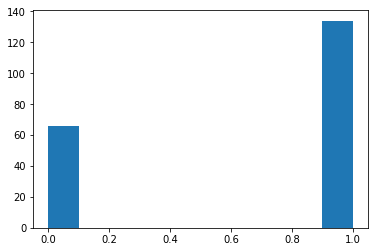

In [9]:
print(y_test.shape)
plt.hist(y_test)
plt.show()

(800,)


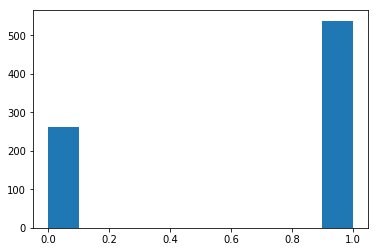

In [10]:
print(y_train.shape)
plt.hist(y_train)
plt.show()

In [11]:
freq = np.unique(y_train, return_counts=True)

In [12]:
print(freq[1])

[262 538]


In [11]:
# 10 fold CV for validation

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
knn = KNeighborsClassifier(n_neighbors=50)

scores = cross_val_score(knn, Xf_train, y_train, cv=10, verbose=2)
print('Accuracy: ', scores.mean(), scores.std() * 2)

[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [14]:
from sklearn.ensemble import RandomForestClassifier
clfrf = RandomForestClassifier(n_estimators=100, max_depth=None,
    min_samples_split=4, random_state=0)

scores = cross_val_score(clfrf, Xf_train, y_train, cv=10, verbose=2)
print('Accuracy: ', scores.mean(), scores.std() * 2)

[CV]  ................................................................
[CV] ................................................. , total=   0.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ................................................. , total=   0.2s
[CV]  ................................................................
[CV] ................................................. , total=   0.2s
[CV]  ................................................................
[CV] ................................................. , total=   0.2s
[CV]  ................................................................
[CV] ................................................. , total=   0.2s
[CV]  ................................................................
[CV] ................................................. , total=   0.2s
[CV]  ................................................................
[CV] ................................................. , total=   0.2s
[CV]  ................................................................
[CV] ................................................. , total=   0.2s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.7s finished


In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clflda = LinearDiscriminantAnalysis()

scores = cross_val_score(clflda, Xf_train, y_train, cv=10, verbose=2)
print('Accuracy: ', scores.mean(), scores.std() * 2)

[CV]  ................................................................
[CV] ................................................. , total=   3.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  

C:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
C:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Anaconda3\l

In [55]:
from sklearn import svm

clfsvm = svm.SVC(gamma=0.1, C = 10, decision_function_shape='ovo')
scores = cross_val_score(clfsvm, Xf_train, y_train, cv=10, verbose=2)
print('Accuracy: ', scores.mean(), scores.std() * 2)

[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [60]:
# test performance

In [61]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [65]:
knn.fit(Xf_train, y_train)
y_p = knn.predict(Xf_test)
print('acc: ', accuracy_score(y_test, y_p))
print('f1: ', f1_score(y_test, y_p))
print('precision: ', precision_score(y_test, y_p))
print('recall: ', recall_score(y_test, y_p))

acc:  0.74
f1:  0.8278145695364237
precision:  0.7440476190476191
recall:  0.9328358208955224


In [66]:
clfrf.fit(Xf_train, y_train)
y_p = clfrf.predict(Xf_test)
print('acc: ', accuracy_score(y_test, y_p))
print('f1: ', f1_score(y_test, y_p))
print('precision: ', precision_score(y_test, y_p))
print('recall: ', recall_score(y_test, y_p))

acc:  0.885
f1:  0.9144981412639405
precision:  0.9111111111111111
recall:  0.917910447761194


In [67]:
clflda.fit(Xf_train, y_train)
y_p = clflda.predict(Xf_test)
print('acc: ', accuracy_score(y_test, y_p))
print('f1: ', f1_score(y_test, y_p))
print('precision: ', precision_score(y_test, y_p))
print('recall: ', recall_score(y_test, y_p))

acc:  0.72
f1:  0.8193548387096773
precision:  0.7215909090909091
recall:  0.9477611940298507


C:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [68]:
clfsvm.fit(Xf_train, y_train)
y_p = clfsvm.predict(Xf_test)
print('acc: ', accuracy_score(y_test, y_p))
print('f1: ', f1_score(y_test, y_p))
print('precision: ', precision_score(y_test, y_p))
print('recall: ', recall_score(y_test, y_p))

acc:  0.9
f1:  0.927007299270073
precision:  0.9071428571428571
recall:  0.9477611940298507


In [104]:
# LSTM approach

In [107]:
Xs_train.shape

(800, 905)

In [135]:
Xs_train = np.reshape(Xs_train, (800,905,1))
print(Xs_train.shape)

Xs_test = np.reshape(Xs_test, (200,905,1))
print(Xs_test.shape)

(800, 905, 1)
(200, 905, 1)


In [136]:
from keras.utils import to_categorical
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

In [143]:
Xs_train_rs = np.reshape(Xs_train, (800, 5, 1, 905//5, 1))
Xs_test_rs = np.reshape(Xs_test, (200, 5, 1, 905//5, 1))
print(Xs_train_rs.shape)
print(Xs_test_rs.shape)

(800, 5, 1, 181, 1)
(200, 5, 1, 181, 1)


[0.06999999999999999, 0.048999999999999995, 0.03429999999999999, 0.024009999999999997, 0.016806999999999996, 0.011764899999999997, 0.008235429999999997, 0.005764800999999997, 0.004035360699999998, 0.0028247524899999983]


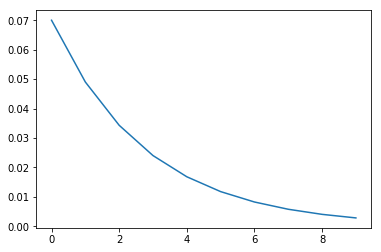

In [238]:
y = [step_decay(x) for x in range(10)]
print(y)
plt.plot(y)
plt.show()

In [248]:
(2<<5) - 1

63

In [257]:
from keras.models import Model
from keras.layers import LSTM, Dense, Dropout, Input, ConvLSTM2D, Flatten, Add, Concatenate, Dot, Multiply
from keras.layers import Maximum, Average, Activation
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import math

def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.7
    epochs_drop = 1.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lrate = LearningRateScheduler(step_decay)

neurons = (2<<5) - 1

t_len = 905
n_class = 2


x_i = Input(shape = (5,1,905//5,1))
x_i2 = Input(shape = (10,))

# bf
x = ConvLSTM2D(filters=128, kernel_size=(1,3), activation='relu')(x_i)
x = Dropout(0.4)(x)
x = Flatten()(x)

#b1
x_pa = Dense(neurons)(x)
x = Activation('relu')(x_pa)
x = Dropout(0.1)(x)

#b2
x_pa2 = Dense(neurons)(x_i2)
x2 = Activation('relu')(x_pa2)
x2 = Dropout(0.1)(x2)
x_dot = Dot(axes=1, normalize=True)([x2, x]) 

# Dot gives 75% test axes=1, normalize=True
# Add 33% Mul got stuck at 75% Max got stuck 70%
# Average stuck 70%

x_add = Concatenate()([x_dot, x_pa])
x_f = Activation('relu')(x_add)

x_add2 = Concatenate()([x_dot, x_pa2])
x_f2 = Activation('relu')(x_add2)

x_dot2 = Dot(axes=1, normalize=True)([x_f, x_f2])

x_add = Concatenate()([x_dot2, x_pa])
x_f = Activation('relu')(x_add)

x_add2 = Concatenate()([x_dot2, x_pa2])
x_f2 = Activation('relu')(x_add2)

x_dot3 = Dot(axes=1, normalize=True)([x_f, x_f2])

x_add = Concatenate()([x_dot3, x_pa])
x_f = Activation('relu')(x_add)

x_add2 = Concatenate()([x_dot3, x_pa2])
x_f2 = Activation('relu')(x_add2)

x_dot4 = Dot(axes=1, normalize=True)([x_f, x_f2])

x_add = Concatenate()([x_dot4, x_pa])
x_f = Activation('relu')(x_add)

x_add2 = Concatenate()([x_dot4, x_pa2])
x_f2 = Activation('relu')(x_add2)

x_dot5 = Dot(axes=1, normalize=True)([x_f, x_f2])

x_add = Concatenate()([x_dot5, x_i2])
x_f = Activation('relu')(x_add)

x_f = Dense(128, activation='relu')(x_f)


x = Dropout(0.2)(x_f)
x_o = Dense(n_class, activation='softmax')(x)


model = Model([x_i, x_i2], x_o)


# checkpoint
filepath="weights-bin-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint, lrate]

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [258]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_90 (InputLayer)           (None, 5, 1, 181, 1) 0                                            
__________________________________________________________________________________________________
conv_lst_m2d_44 (ConvLSTM2D)    (None, 1, 179, 128)  198656      input_90[0][0]                   
__________________________________________________________________________________________________
dropout_83 (Dropout)            (None, 1, 179, 128)  0           conv_lst_m2d_44[0][0]            
__________________________________________________________________________________________________
input_91 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
flatten_40

In [259]:
model.fit([Xs_train_rs, Xf_train], y_train, epochs = 10, batch_size = 64, validation_split=0.15,
        callbacks=callbacks_list)

Train on 680 samples, validate on 120 samples
Epoch 1/10
680/680 [==============================] - 164s 241ms/step - loss: 0.9361 - acc: 0.6471 - val_loss: 0.7670 - val_acc: 0.7167

Epoch 00001: val_acc improved from -inf to 0.71667, saving model to weights-bin-01-0.72.hdf5
Epoch 2/10
680/680 [==============================] - 31s 46ms/step - loss: 0.6419 - acc: 0.7118 - val_loss: 0.5835 - val_acc: 0.7167

Epoch 00002: val_acc did not improve
Epoch 3/10
680/680 [==============================] - 31s 45ms/step - loss: 0.5948 - acc: 0.7324 - val_loss: 0.4912 - val_acc: 0.7833

Epoch 00003: val_acc improved from 0.71667 to 0.78333, saving model to weights-bin-03-0.78.hdf5
Epoch 4/10
680/680 [==============================] - 31s 46ms/step - loss: 0.5324 - acc: 0.7412 - val_loss: 0.4777 - val_acc: 0.7750

Epoch 00004: val_acc did not improve
Epoch 5/10
680/680 [==============================] - 33s 48ms/step - loss: 0.5193 - acc: 0.7588 - val_loss: 0.4582 - val_acc: 0.7833

Epoch 00005: v

In [254]:
model.evaluate([Xs_test_rs, Xf_test], y_test)

200/200 [==============================] - 3s 16ms/step


[0.5074881625175476, 0.765]

In [69]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
sss.get_n_splits(fx, y_mc)

print(sss)       

for train_index, test_index in sss.split(fx, y_mc):
    print("TRAIN:", train_index, "TEST:", test_index)
    Xs_train, Xf_train, Xs_test, Xf_test = x_all[train_index], fx[train_index], x_all[test_index], fx[test_index]
    y_train, y_test = y_mc[train_index], y_mc[test_index]

StratifiedShuffleSplit(n_splits=1, random_state=0, test_size=0.2,
            train_size=None)
TRAIN: [375  26 805 315  83 792 933 815 146 160 111  36 921 877 868 980  61 134
 290 685 466 580  54 234 669 534 287 343 609 678 572 751 941 926 827 666
 112 922  90 228 204 984 548 180 377 885 517 785 477 699 979 312 208 734
 615 549  20 222 632  78 347 703 689 634 216 318 391  56 130   6 392  12
 700 492 110 260 895 226 719  63 411 354 942 248 352 891 302 168 201 578
  43 137 702 543 722 992 720 937 298   2 323 686 874 938 221 782  86 853
 566 796 574 581 894  93 738 712 637 971 335 658 817 807  66 219 623 394
 821 966 636  64 625 890 872 342  95 970 319 557 357 948  45  46 949 756
 537 388 870 173 523 346 480 626 811 119 278 125 642  49 472 524 217 416
 136 187 698  76  37 705  77 631   4  22 607 708 494 109 822 479 944 166
 491 189  62 696 856 393 736 245 129 622 246 945 458 229 428 505  85 659
 206 317 171 292 605 272 906 850 270 687 619 321 563 257  41 397  50 641
 586 859 682 365 419 1

(200,)


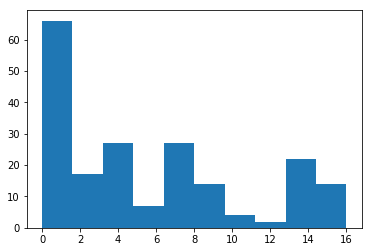

In [70]:
print(y_test.shape)
plt.hist(y_test)
plt.show()

(800,)


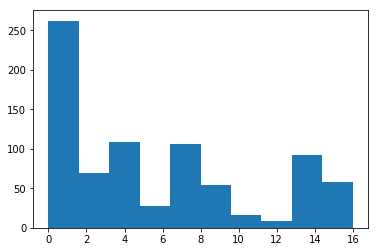

In [71]:
print(y_train.shape)
plt.hist(y_train)
plt.show()

In [59]:
# multi-class classification accuracy

In [72]:
# 10 fold CV

In [81]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
knn = KNeighborsClassifier(n_neighbors=10)

scores = cross_val_score(knn, Xf_train, y_train, cv=10, verbose=2)
print('Accuracy: ', scores.mean(), scores.std() * 2)

[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [83]:
from sklearn.ensemble import RandomForestClassifier
clfrf = RandomForestClassifier(n_estimators=70, max_depth=None,
    min_samples_split=4, random_state=0)

scores = cross_val_score(clfrf, Xf_train, y_train, cv=10, verbose=2)
print('Accuracy: ', scores.mean(), scores.std() * 2)

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


[CV]  ................................................................
[CV] ................................................. , total=   0.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ................................................. , total=   0.1s
[CV]  ................................................................
[CV] ................................................. , total=   0.1s
[CV]  ................................................................
[CV] ................................................. , total=   0.3s
[CV]  ................................................................
[CV] ................................................. , total=   0.3s
[CV]  ................................................................
[CV] ................................................. , total=   0.1s
[CV]  ................................................................
[CV] ................................................. , total=   0.2s
[CV]  ................................................................
[CV] ................................................. , total=   0.2s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.7s finished


In [84]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clflda = LinearDiscriminantAnalysis()

scores = cross_val_score(clflda, Xf_train, y_train, cv=10, verbose=2)
print('Accuracy: ', scores.mean(), scores.std() * 2)

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
C:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:455: User

[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  

C:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [87]:
from sklearn import svm

clfsvm = svm.SVC(gamma=0.1, C = 10, decision_function_shape='ovo')
scores = cross_val_score(clfsvm, Xf_train, y_train, cv=10, verbose=2)
print('Accuracy: ', scores.mean(), scores.std() * 2)

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


In [88]:
# test accuracy for multi-class classification

In [100]:
knn.fit(Xf_train, y_train)
y_p = knn.predict(Xf_test)
print('acc: ', accuracy_score(y_test, y_p))
print('f1: ', f1_score(y_test, y_p, average='macro'))
print('precision: ', precision_score(y_test, y_p, average='macro'))
print('recall: ', recall_score(y_test, y_p, average='macro'))

acc:  0.775
f1:  0.6296000613801583
precision:  0.7075164083228599
recall:  0.6093362777573303


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [101]:
clfrf.fit(Xf_train, y_train)
y_p = clfrf.predict(Xf_test)
print('acc: ', accuracy_score(y_test, y_p))
print('f1: ', f1_score(y_test, y_p, average='macro'))
print('precision: ', precision_score(y_test, y_p, average='macro'))
print('recall: ', recall_score(y_test, y_p, average='macro'))

acc:  0.835
f1:  0.7237770342462201
precision:  0.8032846698822534
recall:  0.6885414035568834


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [102]:
clflda.fit(Xf_train, y_train)
y_p = clflda.predict(Xf_test)
print('acc: ', accuracy_score(y_test, y_p))
print('f1: ', f1_score(y_test, y_p, average='macro'))
print('precision: ', precision_score(y_test, y_p, average='macro'))
print('recall: ', recall_score(y_test, y_p, average='macro'))

acc:  0.605
f1:  0.5163650457972556
precision:  0.5817670528869883
recall:  0.5340180001170713


C:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [103]:
clfsvm.fit(Xf_train, y_train)
y_p = clfsvm.predict(Xf_test)
print('acc: ', accuracy_score(y_test, y_p))
print('f1: ', f1_score(y_test, y_p, average='macro'))
print('precision: ', precision_score(y_test, y_p, average='macro'))
print('recall: ', recall_score(y_test, y_p, average='macro'))

acc:  0.84
f1:  0.7763158831566424
precision:  0.8510032451208922
recall:  0.7463329412245822


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Automatically created module for IPython interactive environment
Computing random projection
Computing PCA projection
Computing Linear Discriminant Analysis projection
Computing Isomap embedding
Done.
Computing LLE embedding
Done. Reconstruction error: 2.92548e-07
Computing modified LLE embedding
Done. Reconstruction error: 0.663335
Computing MDS embedding
Done. Stress: 641389.475580
Computing Totally Random Trees embedding
Computing Spectral embedding


C:\Anaconda3\lib\site-packages\sklearn\utils\graph.py:115: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, np.int)


Computing t-SNE embedding


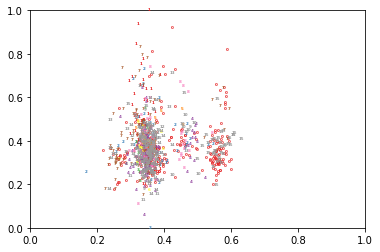

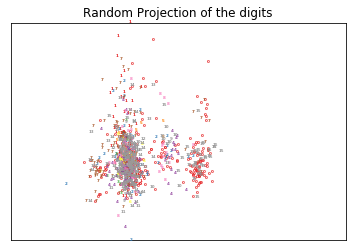

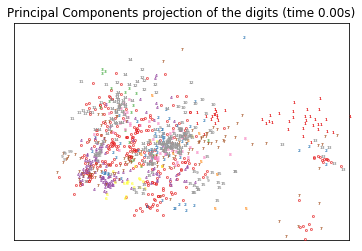

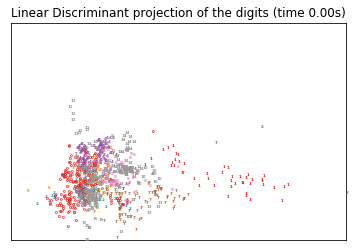

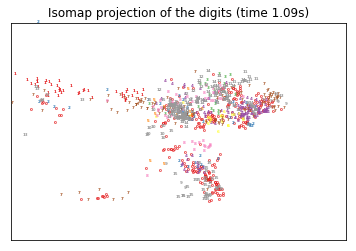

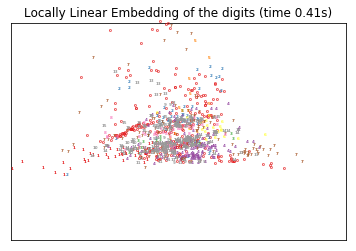

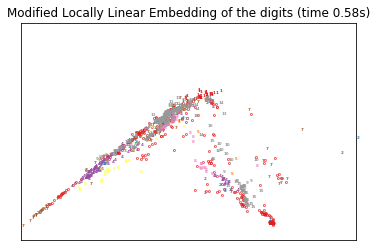

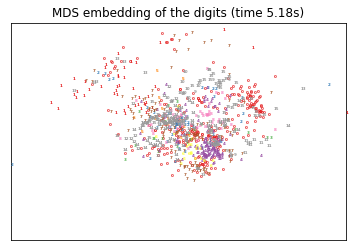

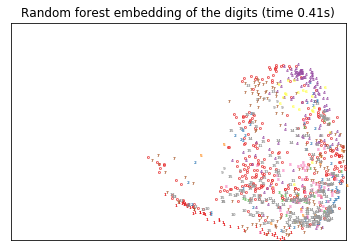

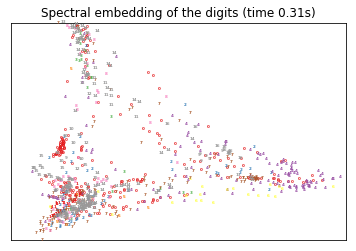

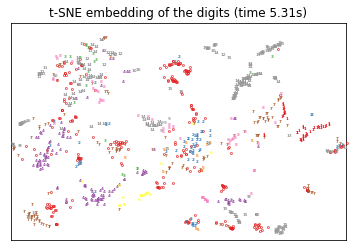

In [43]:
# Authors: Fabian Pedregosa <fabian.pedregosa@inria.fr>
#          Olivier Grisel <olivier.grisel@ensta.org>
#          Mathieu Blondel <mathieu@mblondel.org>
#          Gael Varoquaux
# License: BSD 3 clause (C) INRIA 2011

print(__doc__)
from time import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

digits = datasets.load_digits(n_class=6)
X = fx # digits.data
y = y_mc # digits.target
n_samples, n_features = X.shape
n_neighbors = 30


#----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X), np.max(X)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.) ,
                 fontdict={'weight': 'bold', 'size': 4})

    if False and hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            #ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)


#----------------------------------------------------------------------
# Plot images of the digits



#----------------------------------------------------------------------
# Random 2D projection using a random unitary matrix
print("Computing random projection")
rp = random_projection.SparseRandomProjection(n_components=2, random_state=42)
X_projected = rp.fit_transform(X)
plot_embedding(X_projected, "Random Projection of the digits")


#----------------------------------------------------------------------
# Projection on to the first 2 principal components

print("Computing PCA projection")
t0 = time()
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
plot_embedding(X_pca,
               "Principal Components projection of the digits (time %.2fs)" %
               (time() - t0))

#----------------------------------------------------------------------
# Projection on to the first 2 linear discriminant components

print("Computing Linear Discriminant Analysis projection")
X2 = X.copy()
X2.flat[::X.shape[1] + 1] += 0.01  # Make X invertible
t0 = time()
X_lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=2).fit_transform(X2, y)
plot_embedding(X_lda,
               "Linear Discriminant projection of the digits (time %.2fs)" %
               (time() - t0))


#----------------------------------------------------------------------
# Isomap projection of the digits dataset
print("Computing Isomap embedding")
t0 = time()
X_iso = manifold.Isomap(n_neighbors, n_components=2).fit_transform(X)
print("Done.")
plot_embedding(X_iso,
               "Isomap projection of the digits (time %.2fs)" %
               (time() - t0))


#----------------------------------------------------------------------
# Locally linear embedding of the digits dataset
print("Computing LLE embedding")
clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2,
                                      method='standard')
t0 = time()
X_lle = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_lle,
               "Locally Linear Embedding of the digits (time %.2fs)" %
               (time() - t0))


#----------------------------------------------------------------------
# Modified Locally linear embedding of the digits dataset
print("Computing modified LLE embedding")
clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2,
                                      method='modified')
t0 = time()
X_mlle = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_mlle,
               "Modified Locally Linear Embedding of the digits (time %.2fs)" %
               (time() - t0))


#----------------------------------------------------------------------
# HLLE embedding of the digits dataset


#----------------------------------------------------------------------
# LTSA embedding of the digits dataset

#----------------------------------------------------------------------
# MDS  embedding of the digits dataset
print("Computing MDS embedding")
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100)
t0 = time()
X_mds = clf.fit_transform(X)
print("Done. Stress: %f" % clf.stress_)
plot_embedding(X_mds,
               "MDS embedding of the digits (time %.2fs)" %
               (time() - t0))

#----------------------------------------------------------------------
# Random Trees embedding of the digits dataset
print("Computing Totally Random Trees embedding")
hasher = ensemble.RandomTreesEmbedding(n_estimators=200, random_state=0,
                                       max_depth=5)
t0 = time()
X_transformed = hasher.fit_transform(X)
pca = decomposition.TruncatedSVD(n_components=2)
X_reduced = pca.fit_transform(X_transformed)

plot_embedding(X_reduced,
               "Random forest embedding of the digits (time %.2fs)" %
               (time() - t0))

#----------------------------------------------------------------------
# Spectral embedding of the digits dataset
print("Computing Spectral embedding")
embedder = manifold.SpectralEmbedding(n_components=2, random_state=0,
                                      eigen_solver="arpack")
t0 = time()
X_se = embedder.fit_transform(X)

plot_embedding(X_se,
               "Spectral embedding of the digits (time %.2fs)" %
               (time() - t0))

#----------------------------------------------------------------------
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

plt.show()

In [249]:
# ref:
# https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1
# scikit-learn